In [1]:
from models import RMSELoss
from torch.utils.data import Dataset, DataLoader
import utils as ut
import torch
from datasets import FrameDataset
import train_nvidia_model as tnm
import os 
import numpy as np
import random 
import matplotlib.pyplot as plt
from torch import nn
import functools
import operator
import shutil

In [2]:
import torch
import torch.utils.data


class _RepeatSampler(object):
    """ Sampler that repeats forever.

    Args:
        sampler (Sampler)
    """

    def __init__(self, sampler):
        self.sampler = sampler

    def __iter__(self):
        while True:
            yield from iter(self.sampler)


class FastDataLoader(torch.utils.data.dataloader.DataLoader):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        object.__setattr__(self, 'batch_sampler', _RepeatSampler(self.batch_sampler))
        self.iterator = super().__iter__()

    def __len__(self):
        return len(self.batch_sampler.sampler)

    def __iter__(self):
        for i in range(len(self)):
            yield next(self.iterator)

In [3]:
#%matplotlib inline

In [4]:
seed = 1729
def reset_rand_seed(): 
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
reset_rand_seed()
#torch.use_deterministic_algorithms(True)

In [5]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(dev)

cuda


In [6]:
#if a conv layer is followed by a batchnorm, don't use bias (it cancel the effect so it's useless)
class NvidiaModel(nn.Module):
    def __init__(self, img_size: list[int]):
        super(NvidiaModel, self).__init__()

        self.cnn = nn.Sequential(
            nn.BatchNorm2d(3),
            
            nn.Conv2d(3, 24, 5, 2),
            # nn.BatchNorm2d(24),
            nn.ReLU(),
            # nn.MaxPool2d(2, 2),

            nn.Conv2d(24, 36, 5, 2),
            # nn.BatchNorm2d(36),
            nn.ReLU(),

            nn.Conv2d(36, 48, 5, 2),
            # nn.BatchNorm2d(48),
            nn.ReLU(),

            nn.Conv2d(48, 64, 3, 1),
            # nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, 3, 1),
            # nn.BatchNorm2d(64),
            nn.ReLU(),

            # nn.Conv2d(64, 128, 3, 2),
            # # nn.BatchNorm2d(128),
            # nn.ReLU(),

            # nn.Conv2d(128, 256, 3, 2),
            # nn.BatchNorm2d(256),
            # nn.ReLU(),


            # nn.AdaptiveAvgPool2d(1),
            # nn.AvgPool2d(2),

            nn.Flatten(1)
        )
        h, w = img_size
        out = self.cnn(torch.zeros(1, 3, h, w))
        self.cnn_shape_out = functools.reduce(operator.mul, list(out.shape))
        
        #self.dropout = nn.Dropout(0.5)

        self.linear = nn.Sequential(
            nn.Linear(self.cnn_shape_out, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.ReLU(), 
            nn.Linear(10, 2),
        )

    def forward(self, X):
        out = self.cnn(X)
        #out = self.dropout(out)
        out = self.linear(out)
        return out

In [7]:
# class FrameDataset(Dataset):
#     def __init__(self, frames_dir, angles_file, start_idx, end_idx):
#         self.frames = ut.load_frames(frames_dir, start_idx, end_idx)
#         self.angles = torch.tensor(ut.read_angles(angles_file)[start_idx:end_idx])

#     def __getitem__(self, idx):
#         return (self.frames[idx], self.angles[idx])

#     def __len__(self):
#         return len(self.angles)

In [8]:
data_dir = "data_h3_w3"
videos = [0, 1, 2, 3, 4]
train_dir = os.path.join(data_dir, "train")
train_dir = os.path.join(train_dir, "cropped")
valid_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")
train_dirs = [os.path.join(train_dir, str(video)) for video in videos]
valid_dirs = [os.path.join(valid_dir, str(video)) for video in videos]
test_dirs = [os.path.join(test_dir, str(video)) for video in videos]
train_angles_files = [os.path.join(td, "angles.txt") for td in train_dirs]
valid_angles_files = [os.path.join(vd, "angles.txt") for vd in valid_dirs]
test_angles_files = [os.path.join(td, "angles.txt") for td in test_dirs]

In [9]:
# basic_train_dir = os.path.join(data_dir, "basic_train/0")
# a = os.path.join(basic_train_dir, "angles.txt")
# ds = FrameDataset(basic_train_dir, a, 0, 10)
# def show_img(img, t=None):
#     if t is not None:
#         img = t(img)
#     plt.imshow(img.permute(1, 2, 0))

In [10]:
train_datasets = [FrameDataset(frame_dir, angles_file) for frame_dir, angles_file in zip(train_dirs, train_angles_files)]
valid_datasets = [FrameDataset(frame_dir, angles_file) for frame_dir, angles_file in zip(valid_dirs, valid_angles_files)]
test_datasets = [FrameDataset(frame_dir, angles_file) for frame_dir, angles_file in zip(test_dirs, test_angles_files)]

In [11]:
def seed_worker(worker_id):
    # worker_seed = torch.initial_seed() % 2**32
    worker_seed = seed
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

w = torch.Generator()
w.manual_seed(seed)

t = torch.Generator()
t.manual_seed(seed)

batch_size = 32
num_workers = 4
shuffle = False

train_dataloaders = [
    FastDataLoader(train_ds, batch_size,
    num_workers=num_workers, shuffle=shuffle, pin_memory=True) 
    for train_ds in train_datasets]

valid_dataloaders = [
    FastDataLoader(valid_ds, batch_size, 
    num_workers=num_workers, shuffle=False, pin_memory=True) 
    for valid_ds in valid_datasets]

test_dataloaders = [
    FastDataLoader(test_ds, 1, 
    num_workers=num_workers, shuffle=False, pin_memory=True) 
    for test_ds in test_datasets]

RuntimeError: Couldn't open shared file mapping: <00000242B1997BD2>, error code: <1455>

In [ ]:
img_size = (120, 360)

In [ ]:
model = NvidiaModel(img_size)
model.to(dev)
opt = torch.optim.AdamW(model.parameters(), lr=3e-04)
loss = RMSELoss()
#shutil.rmtree("test_1")
history = tnm.History("test_1", videos, model, opt, loss, None, batch_size)
epochs = 15
tnm.fit(epochs, history, train_dataloaders, valid_dataloaders, dev, verbose=True)

Start epoch #0...


RuntimeError: DataLoader worker (pid(s) 3456, 4168) exited unexpectedly

'YOUR ERROR SCORE IS 46.53% (lower is better)'

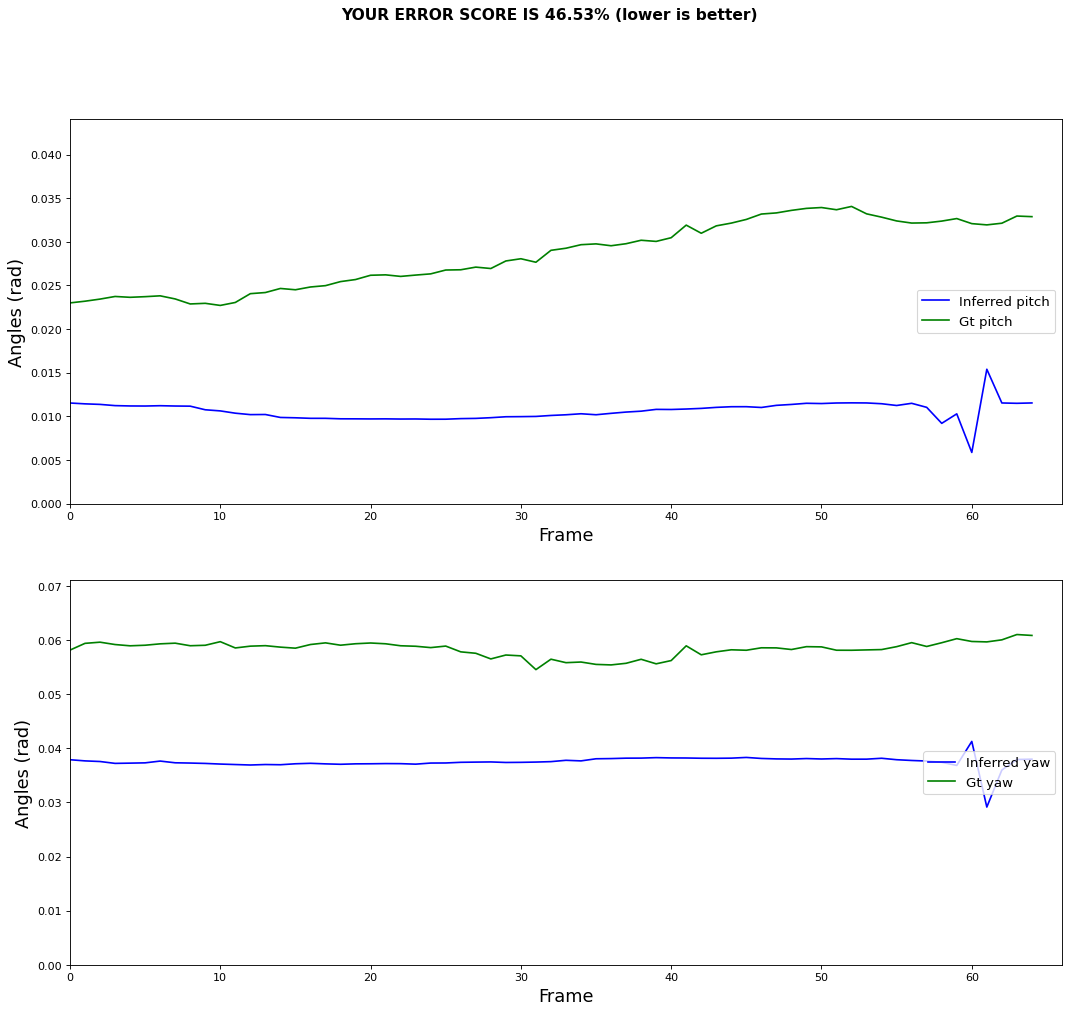

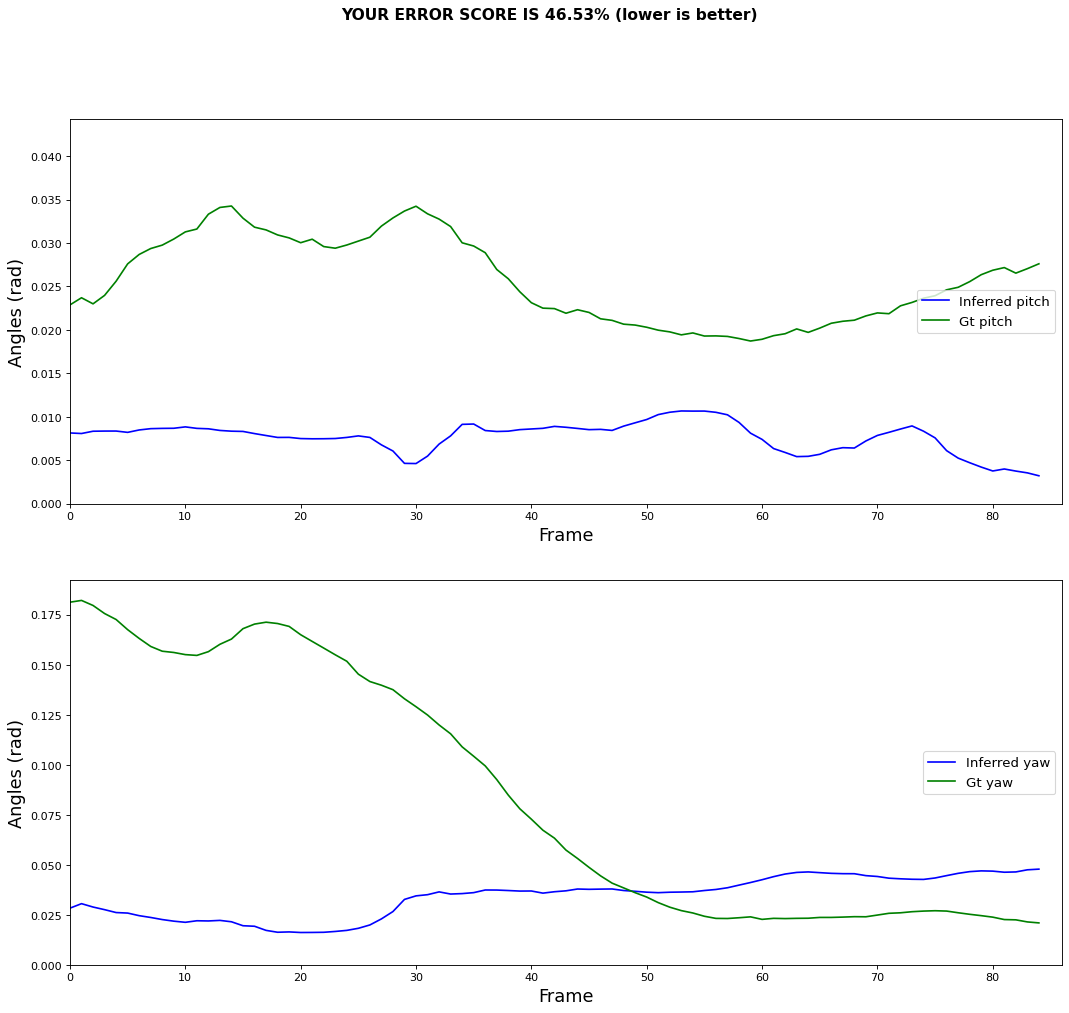

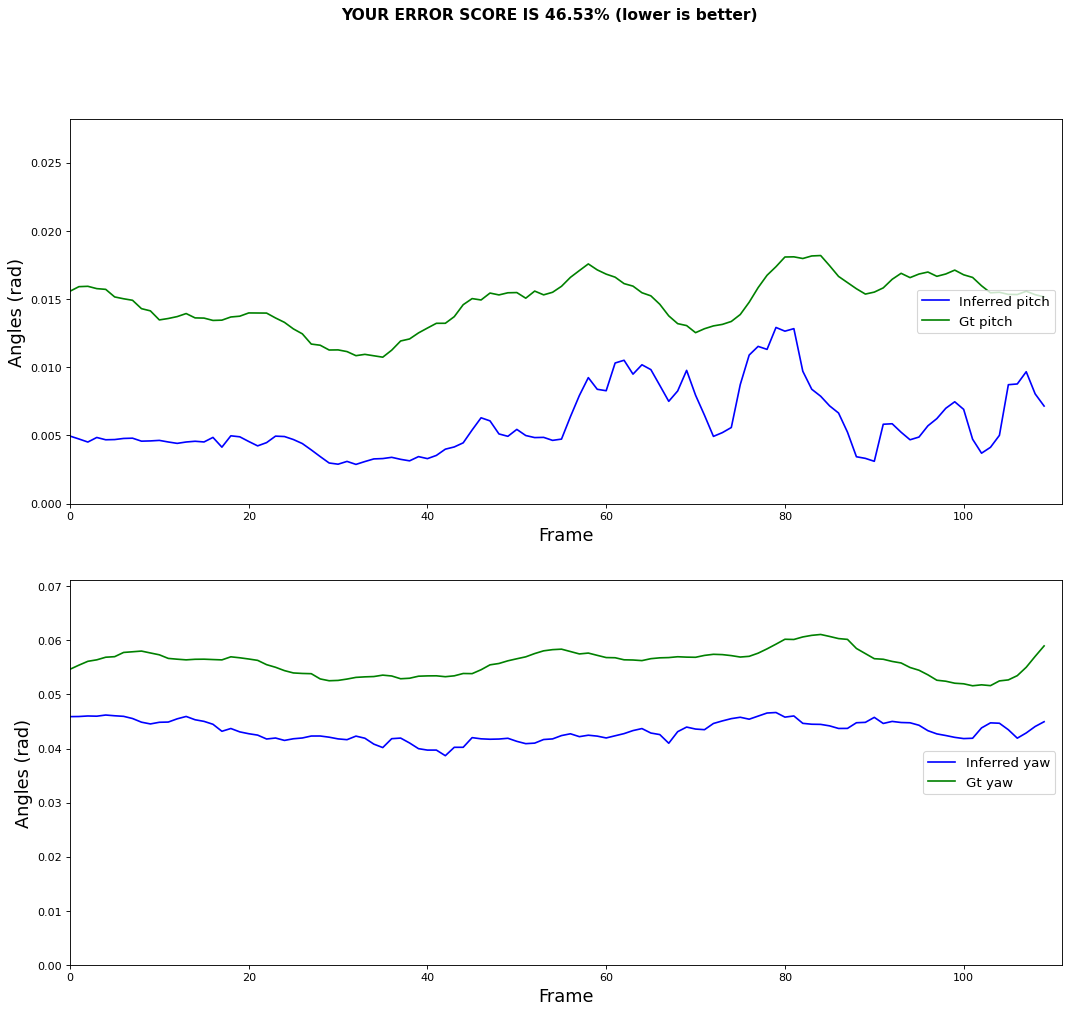

In [ ]:
history.test_model(test_dataloaders, dev)